## 3. Frequent Subgraph Mining (FSM) with gSpan

*Glenn:*
> This information is used to define the lower_bound_of_num_vertices for the Frequent Subgraph Mining (FSM) algorithm. 
> From the perspective of CCM reviewers and audience ("doctors"):
> Imagine they are overseeing one of our patients at Emory remotely. They are only a single update exactly every hour with just the SOFA/MODS scores.
> 1. What is the smallest number of hours of SOFA/MODS that would be consider a clinical "signal"?  What is the smallest period of time the "doctor" would be willing to consider something clinically relevant.
>   - The "lower bound" on the number of vertices defines the minimum number of node needed to form a 'subgraph'.
> 2. Conversely, how many hours is "too long"? If a doctor was willing to wait eight hours while the score fluctuates, would that be acceptable? e.g. a patient renal score is bouncing between 0-1-0-1-0-1 etc. How long would a doctor be willing to wait and observe the patient.
>   - The "upper bound" on the number of vertices defines the maximum number of node allowed to form a 'subgraph'.
> 3. How many times would a clinician need to see a certain SOFA/MODS score pattern before they would remember it for the future? How many patients would a doctor need to see in order for their brain to begin considering it a 'pattern'. (note: distinctly not the same as our phenotypes)
>   - The "support" is the number of encounters that must exhibit the 'pattern' to be considered valid.
>   - For our purposes, we could consider a flat number or a percentage of the overall dataset (e.g. n_support=300, pct_support=0.20)
> Based on a review of the literature, our 24-hour time-pan and  I recommend we begin exploring the following parameter space for the "out-of-the-box" version of the gSpan algorithm (which can be modified to improve performance and fit MODS use-case):
> - lower_bound_of_num_vertices = [2,3,4]
> - upper_bound_of_num_vertices = [4,5,6]
> - pct_support = [0.05, 0.10, 0.15]
> Once we get initial results and confirm it is working I will expand the parameter space and use RayTune to distribute experimentation over a wider and more granular parameter space.> 
> P.S. Are MODS scores only updated once every hour? What is the finest level of granularity we could expect the SOFA/MODS scores to update on? GCS is physician administered so it has the greatest lag time. However all the other scores could be calculated based on data being gathered in real-time. Could I look at scores every half-hour, fifteen minutes, every minute, or even less? I know that for most EHRs (e.g. EPIC) they only usually have granularity at the minute-level but our timestamps are in nanosecond format.


*Sanchez-Pinto, 2020*
> This cohort study included 20 827 pediatric intensive care encounters among 14 285 children admitted to 2 large academic pediatric intensive care units (PICUs) between January 2010 and August 2016.

> The number of subgraphs was then reduced by eliminating: (1) small subgraphs
contained within larger subgraphs in order to reduce double-counting; (2) subgraphs that were static and did not have a maximum subscore of more than 2 in order to reduce the influence of organs with mild or no dysfunction and no change; and (3) subgraphs present in less than 20 patients in order to focus on more representative subgraph

Support == 0.01% of total (20 / 20_000)

Therefore: `support = int((20/20_000) * count_of_encounters)`

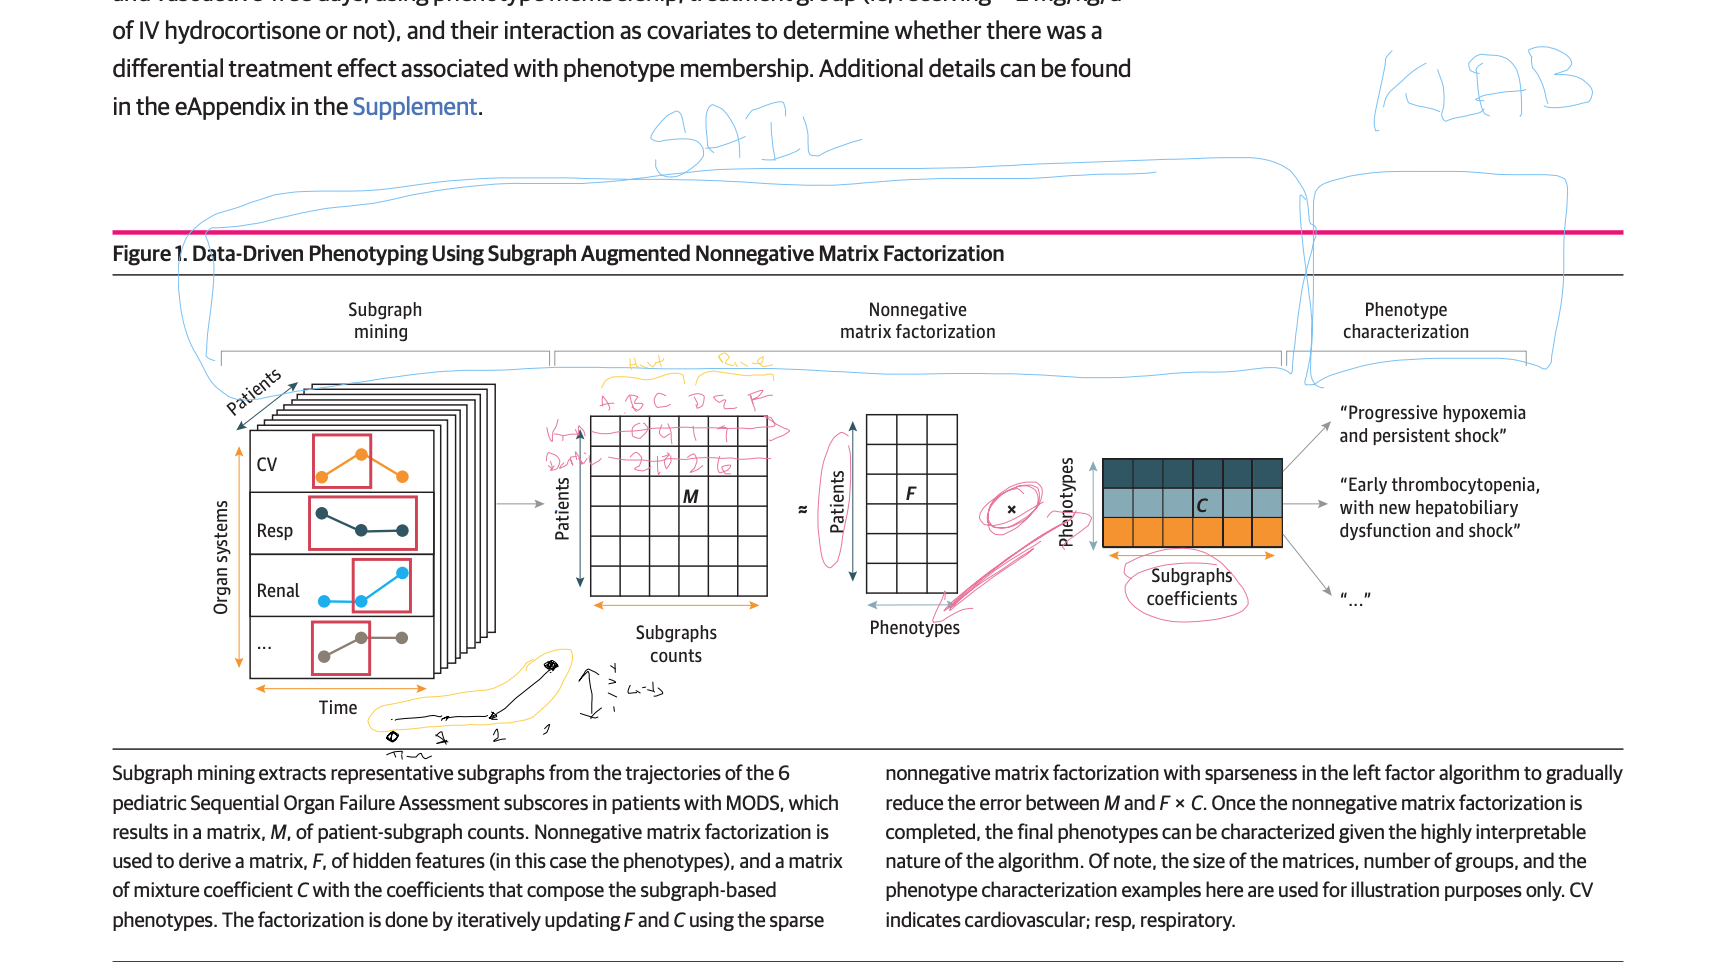

In [ ]:
from gspan_mining.config import parser
from gspan_mining.main import main

## Development Area

### Parse Data to Graph

In [ ]:
def write_graph_data(dat_id):
    # Add the vertices
    vertices_df = score_df.loc[dat_id, score_col].reset_index()
    
    if len(vertices_df) < 2:
        return
    else:
        # Start the string representation of the graph
        output_str = f"t # {dat_id}\n"

        vertices_str = "v" + vertices_df.to_string(header=False, index=False).replace('\n', '\nv ') + "\n"
        output_str += vertices_str

        # Add the edges
        edges_df = score_df.loc[dat_id, score_col].diff(periods=1).reset_index()
        edges_df.rename(columns={'time_1D': 'time_1D_to'}, inplace=True)
        edges_df['time_1D_from'] = edges_df['time_1D_to'] - 1
        edges_df[score_col] = edges_df[score_col].replace(np.nan, 0).astype(int)
        edges_df = edges_df[['time_1D_from', 'time_1D_to', score_col]]
        edges_df = edges_df.iloc[1:, :]
        output_str += "e" + edges_df.to_string(header=False, index=False).replace('\n', '\ne ') + "\n"

        # End the graph and output string
        output_str = output_str.replace('  ', ' ').replace('e0', 'e 0').replace('v0', 'v 0')
        with open(fp, 'a') as f:
            f.write(output_str)

In [ ]:
def process_graph_data(score_df):
    # grab score data
    global df
    df = score_df
    # get the unique data IDs in our dataset
    global data_ids
    data_ids = df.index.get_level_values(0).unique()
    
    fps = []

    # sofa-scores post sepsis 1 day as graph (vertices/edges) in a format accepted by `gspan-mining`
    for col in tq.tqdm(sofa_score_cols):
        global score_col
        score_col = col
        global fp
        fp = Path.cwd() / f"{score_col}.output"
        fps.append(fp)

        # create an empty file to append results to
        if fp.exists():
            fp.unlink()

        with open(fp, 'w') as f:
            pass

        pool = Pool(processes=num_cpus)

        for result in tq.tqdm(pool.imap(func=write_graph_data, iterable=data_ids), total=len(data_ids)):
            pass
    return fps

In [ ]:
def graph_mining(graph_data_fp,
                 support=1,
                 l=3,
                 u=6,
                 directed=True,
                 verbose=False,
                 plot=False,
                 where=False):
    args_str = f"{str(graph_data_fp)} -s {str(support)} -l {str(l)} -u {str(u)} -d {str(directed)} -v {str(verbose)} -p {str(plot)} -w {str(where)}"
    FLAGS, _ = parser.parse_known_args(args=args_str.split())
    gs = main(FLAGS)
    return gs

In [ ]:
score_df = sepsis_1D_df[sofa_score_cols]

In [ ]:
graph_data_fps = process_graph_data(score_df)

In [ ]:
support = int((20/20_000)*len(data_ids))

In [ ]:
SOFA_cardio_score_gSpan = graph_mining(graph_data_fps[4], support=support)

In [ ]:
report_df = SOFA_cardio_score_gSpan._report_df

In [ ]:
report_df

## 4. Non-Negative Matrix Factorization of the gSpan Results

[The why and how of nonnegative matrix factorization](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/)

[NMF — A visual explainer and Python Implementation](https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8)

## Sandbox Area

## OLD FSM CODE